In [8]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns

# Get the absolute path to the project root directory
project_root = '/workspace'
sys.path.append(project_root)

# import prepare_data
from src.python.preprocess import prepare_data


# 1.Prepare data

In [2]:
# Load data
df = pd.read_csv(f'{project_root}/data/LC_engineered.csv')

# Drop unwanted features
target = 'Duration_In_Min'
target_2 = 'Occupancy'
features_to_drop = ['Student_IDs', 'Semester', 'Class_Standing', 'Major', 'Expected_Graduation',
                    'Course_Name', 'Course_Number', 'Course_Type', 'Course_Code_by_Thousands',
                    'Check_Out_Time', target, target_2] #'Session_Length_Category'

X, y = prepare_data(df, target, features_to_drop)

# 2. Check for Non-Linear Relationships

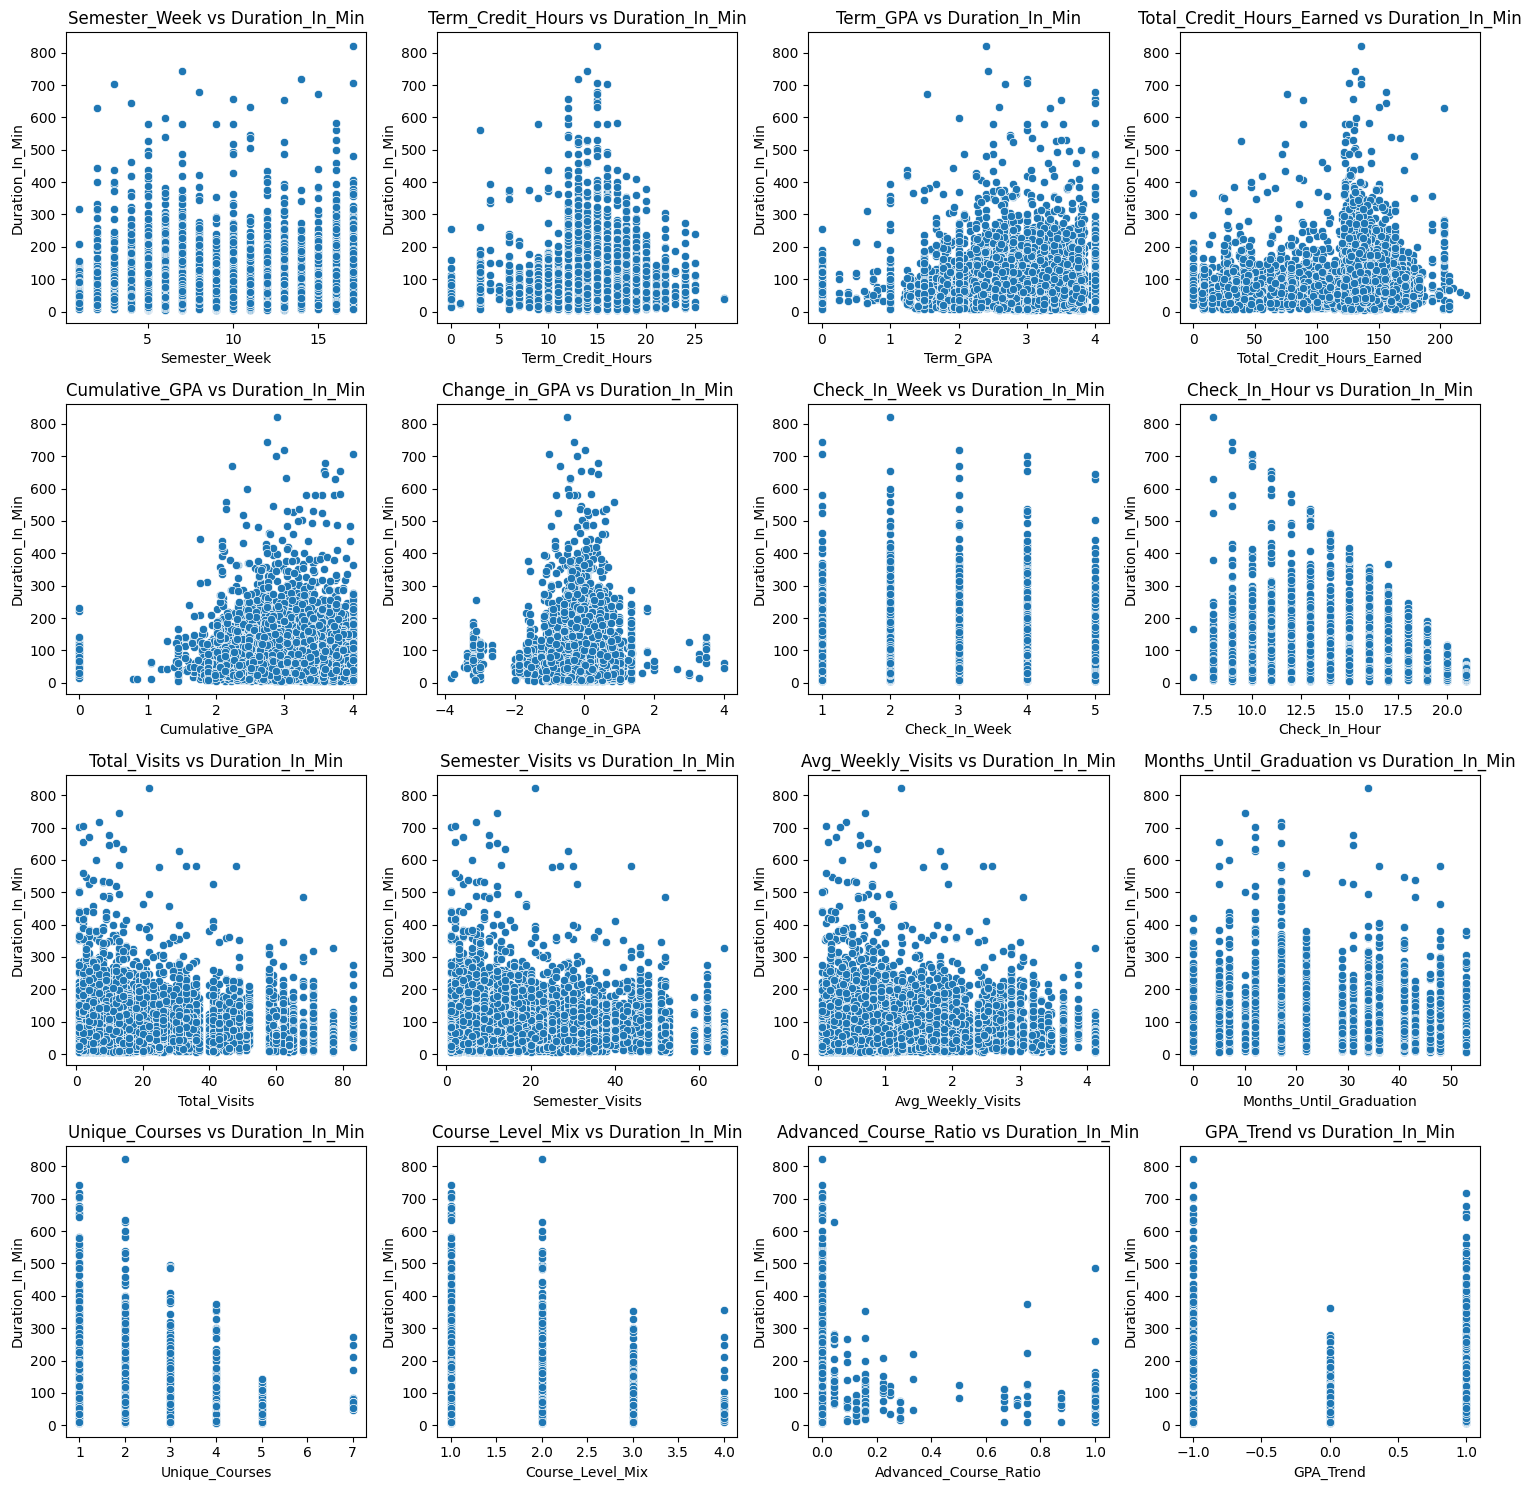

In [3]:
# Get numeric columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
n_cols = len(numeric_cols)

# Calculate grid dimensions (trying to make it roughly square)
n_rows = int(np.ceil(np.sqrt(n_cols)))
n_cols_grid = int(np.ceil(n_cols / n_rows))

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols_grid, figsize=(15, 15))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot each feature vs. the target
for idx, column in enumerate(numeric_cols):
    sns.scatterplot(x=X[column], y=y, ax=axes[idx])
    axes[idx].set_title(f"{column} vs {target}")
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel(target)

# Remove empty subplots if any
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


# 3. Identify Feature Interactions

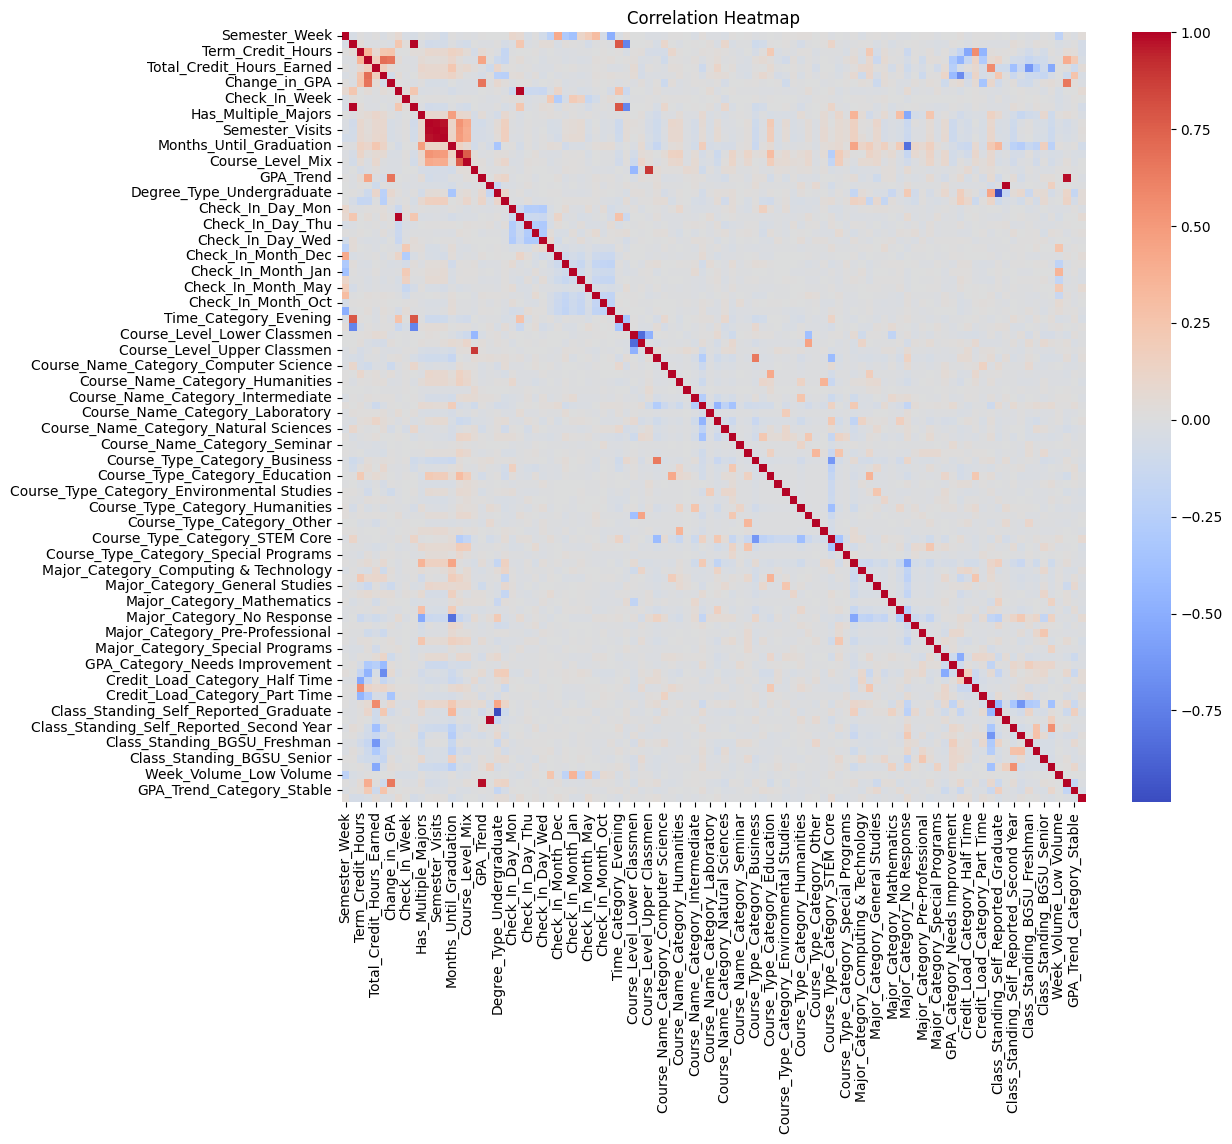

In [4]:
# Correlation matrix
correlation_matrix = pd.concat([X, y], axis=1).corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [13]:
top_x = 20

# Convert correlation matrix to a series of pairs with their correlation values
correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):  # Start from i+1 to avoid duplicates and self-correlations
        correlations.append({
            'feature1': correlation_matrix.columns[i],
            'feature2': correlation_matrix.columns[j],
            'correlation': abs(correlation_matrix.iloc[i, j])  # Use abs() for magnitude
        })

# Convert to DataFrame and sort by absolute correlation
corr_df = pd.DataFrame(correlations)
top_x_correlations = corr_df.sort_values('correlation', ascending=False).head(top_x)

# Display the results
print(f"Top {top_x} Feature Correlations by Magnitude:")
print(top_x_correlations.to_string(index=False))


Top 20 Feature Correlations by Magnitude:
                   feature1                              feature2  correlation
                 Is_Weekend                      Check_In_Day_Sun     1.000000
    Degree_Type_No response    Class_Standing_Self_Reported_Other     1.000000
              Check_In_Time                         Check_In_Hour     0.995715
            Semester_Visits                     Avg_Weekly_Visits     0.988607
  Degree_Type_Undergraduate Class_Standing_Self_Reported_Graduate     0.987054
               Total_Visits                       Semester_Visits     0.986028
                  GPA_Trend          GPA_Trend_Category_Improving     0.982542
               Total_Visits                     Avg_Weekly_Visits     0.976542
      Advanced_Course_Ratio           Course_Level_Upper Classmen     0.883689
Course_Level_Lower Classmen                  Course_Level_Special     0.839614
    Months_Until_Graduation            Major_Category_No Response     0.818504
          

In [12]:
# sns.pairplot(pd.concat([X, y], axis=1), diag_kind="kde")
# plt.show()

: 

# 5. Interaction Terms

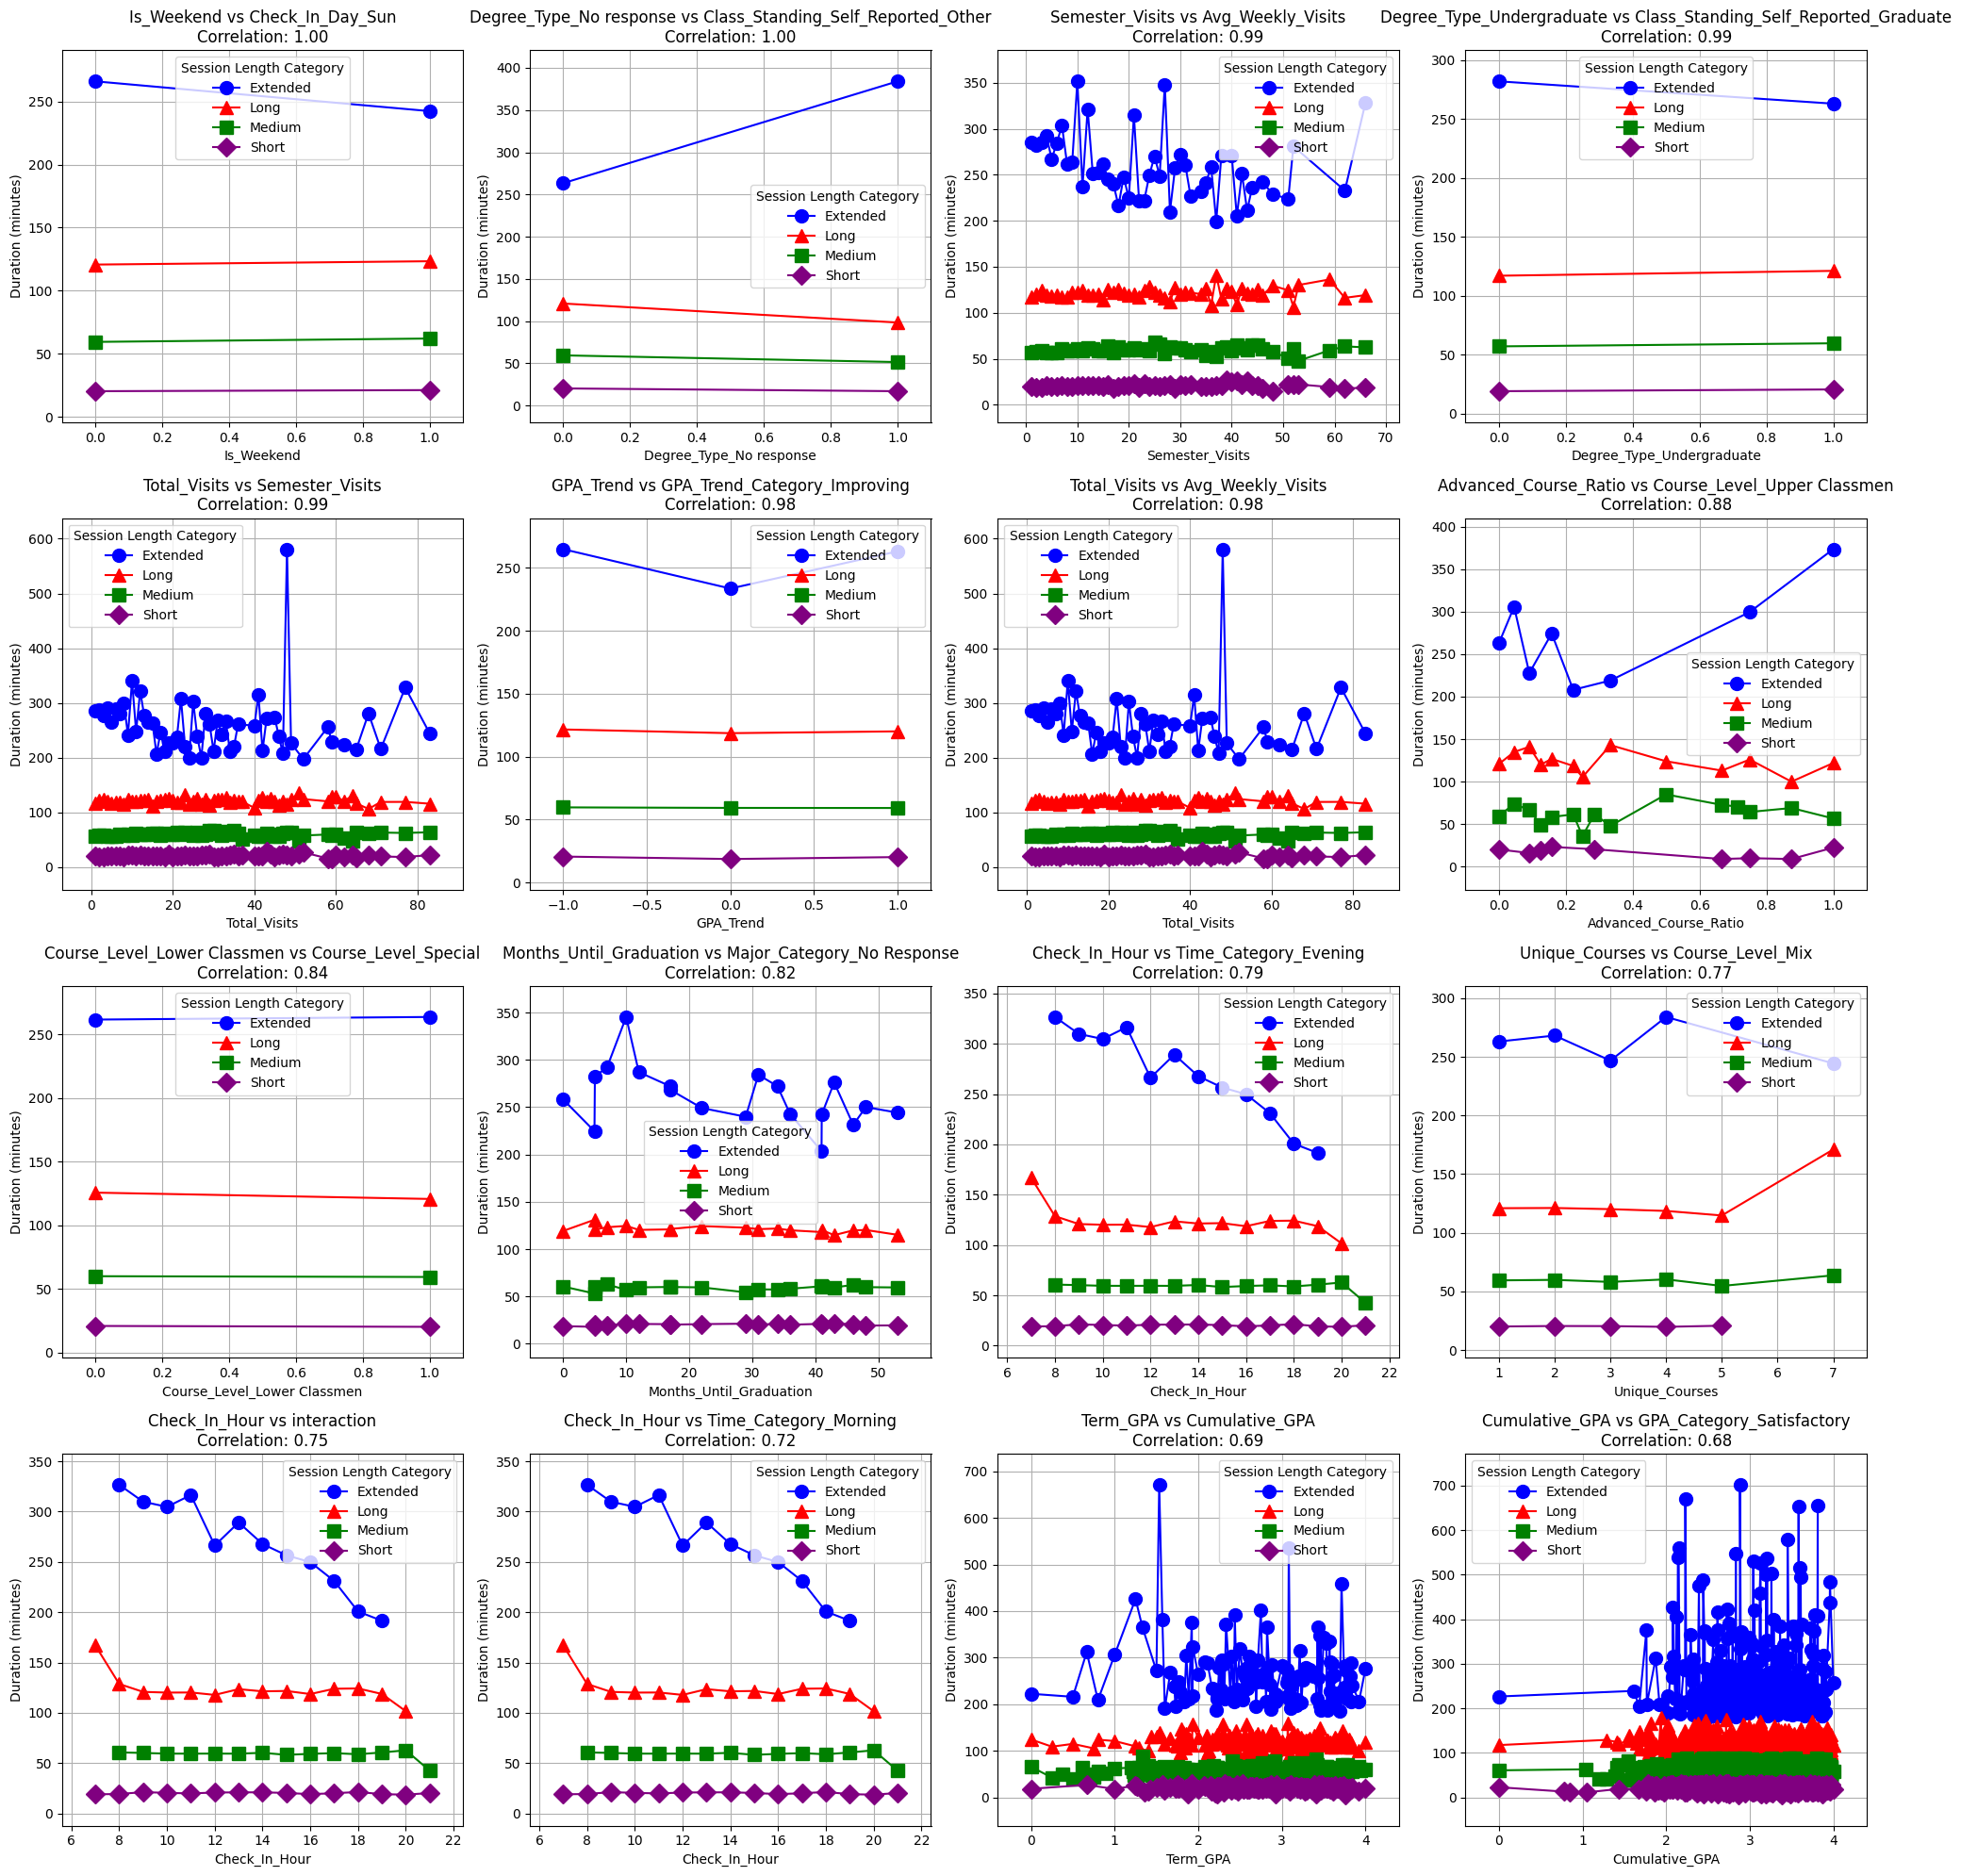

In [25]:
# Get numeric columns
numeric_cols = X.select_dtypes(include=['float64', 'int64', 'bool']).columns

# Optional: Get top N most correlated pairs
n_pairs = 16  # Adjust this number for more/fewer plots
correlations = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr = abs(X[numeric_cols[i]].corr(X[numeric_cols[j]]))
        correlations.append((numeric_cols[i], numeric_cols[j], corr))

# Sort by correlation and get top pairs
top_pairs = sorted(correlations, key=lambda x: x[2], reverse=True)[:n_pairs]

# Create subplot grid
n_rows = int(np.ceil(np.sqrt(n_pairs)))
n_cols_grid = n_rows
fig, axes = plt.subplots(n_rows, n_cols_grid, figsize=(20, 20))
axes = axes.flatten()

# Create interaction plots for each pair
for idx, (feature1, feature2, corr) in enumerate(top_pairs):
    if idx < len(axes):
        try:
            # Create the interaction plot using Session_Length_Category
            interaction_plot(X[feature1], df['Session_Length_Category'], y, 
                            colors=['blue', 'red', 'green', 'purple'],
                            markers=['o', '^', 's', 'D'],
                            ms=10, ax=axes[idx])
            
            axes[idx].set_title(f'{feature1} vs {feature2}\nCorrelation: {corr:.2f}')
            axes[idx].set_xlabel(feature1)
            axes[idx].set_ylabel('Duration (minutes)')
            axes[idx].legend(title='Session Length Category')
            axes[idx].grid(True)
        except Exception as e:
            print(f"Skipping plot for {feature1} vs {feature2}: {str(e)}")
            if idx < len(axes):
                fig.delaxes(axes[idx])

# Remove empty subplots if any
for idx in range(len(top_pairs), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Here's what to look for:
1. Non-parallel or crossing lines:
- If the lines for different Session_Length_Categories have very different slopes
- If the lines cross each other
- These patterns suggest that the effect of the feature on Duration_In_Minutes depends on the session length category, indicating a potential interaction

2. Parallel lines:
- If the lines are roughly parallel
- This suggests NO significant interaction, as the effect of the feature on Duration_In_Minutes is consistent regardless of session length category


In [21]:
# Get top N correlated pairs (reuse the correlation calculation from earlier)
n_pairs = 10  # Adjust number of top pairs to test
correlations = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr = abs(X[numeric_cols[i]].corr(X[numeric_cols[j]]))
        correlations.append((numeric_cols[i], numeric_cols[j], corr))

top_pairs = sorted(correlations, key=lambda x: x[2], reverse=True)[3:n_pairs]

# Test each pair in a regression model
for feature1, feature2, corr in top_pairs:
    print(f"\nTesting interaction between {feature1} and {feature2} (correlation: {corr:.3f})")
    print("-" * 80)
    
    # Create interaction term
    interaction_name = f"{feature1}_{feature2}_interaction"
    X_temp = X[[feature1, feature2]].copy()
    X_temp[interaction_name] = X[feature1] * X[feature2]
    
    # Fit regression model
    X_const = sm.add_constant(X_temp)
    model = sm.OLS(y, X_const).fit()
    
    # Print summary
    print(model.summary().tables[1])  # Print only the coefficients table for brevity
    print("\n")


Testing interaction between Unique_Courses and Course_Level_Mix (correlation: 0.766)
--------------------------------------------------------------------------------
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          77.0210      2.839     27.134      0.000      71.457      82.585
Unique_Courses                                 -4.5056      1.505     -2.994      0.003      -7.455      -1.556
Course_Level_Mix                               11.7405      2.326      5.047      0.000       7.181      16.300
Unique_Courses_Course_Level_Mix_interaction    -1.1640      0.693     -1.679      0.093      -2.523       0.195



Testing interaction between Check_In_Hour and interaction (correlation: 0.749)
-------------------------------------------------------------------------------

# 6. Mutual Information for Feature Importance

Mutual Information Scores (sorted):
                  Feature  MI Score
             Total_Visits  0.056557
        Avg_Weekly_Visits  0.051700
Total_Credit_Hours_Earned  0.047332
          Semester_Visits  0.046007
            Change_in_GPA  0.045484
           Cumulative_GPA  0.042627
            Check_In_Hour  0.034100
              interaction  0.024660
                 Term_GPA  0.021245
            Semester_Week  0.018672
           Unique_Courses  0.015099
    Advanced_Course_Ratio  0.008750
  Months_Until_Graduation  0.007721
        Term_Credit_Hours  0.005937
         Course_Level_Mix  0.002979
            Check_In_Week  0.000000
                GPA_Trend  0.000000

Interpretation:
- Higher scores (closer to 1) indicate stronger relationships
- Lower scores (closer to 0) indicate weaker relationships


<Figure size 1200x600 with 0 Axes>

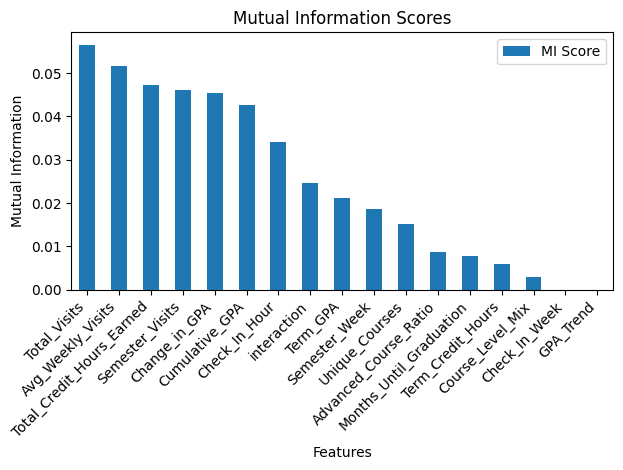

In [22]:
# Compute mutual information
mi_scores = mutual_info_regression(X.select_dtypes(include=['float64', 'int64']), y)
mi_scores = pd.Series(mi_scores, index=X.select_dtypes(include=['float64', 'int64']).columns)

# Create DataFrame with scores and sort
mi_df = pd.DataFrame({
    'Feature': mi_scores.index,
    'MI Score': mi_scores.values
}).sort_values('MI Score', ascending=False)

# Print sorted scores
print("Mutual Information Scores (sorted):")
print(mi_df.to_string(index=False))
print("\nInterpretation:")
print("- Higher scores (closer to 1) indicate stronger relationships")
print("- Lower scores (closer to 0) indicate weaker relationships")

# Plot
plt.figure(figsize=(12, 6))
mi_df.plot(x='Feature', y='MI Score', kind='bar')
plt.title("Mutual Information Scores")
plt.xlabel("Features")
plt.ylabel("Mutual Information")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()